In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
def th_bin(img, s_th=(170, 255), x_th=(20, 100)):
    img = np.copy(img)
    # Prepare thresholded binary for S-Channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_th[0]) & (s_channel <= s_th[1])] = 1
    # Prepare thresholded binary for X-gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x dir
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= x_th[0]) & (scaled_sobel <= x_th[1])] = 1
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

def warp(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [3]:
class Line():
    def __init__(self):
        self.fit = None
        self.curv = None
        self.x = None

def gen_fit(img, start_x, line, win_h=40, win_w=100):
        
    ym_per_pix = 3/64 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meteres per pixel in x dimension
    
    y_size = img.shape[0]
    num_stripes = int(y_size/win_h)
    mask = np.zeros_like(img)
    median = start_x
    for i in range(num_stripes):
        y_li = y_size - (i+1)*win_h
        y_ri = y_li + win_h
        x_li = max(0, (median - win_w))
        x_ri = min(img.shape[1], (median + win_w))
        mask[y_li:y_ri, x_li:x_ri] = np.ones((win_h, x_ri - x_li))        
        win = img[y_li:y_ri, x_li:x_ri]
        win_ones = np.where(win == 1)
        if (len(win_ones[1]) > 1):
            median = int(np.median(win_ones[1])) + x_li
    
    masked_img = cv2.bitwise_and(img, mask)
    masked_ones = np.where(masked_img == 1)

    if (len(masked_ones[0]) > 5000):
        line.fit = np.polyfit(masked_ones[0], masked_ones[1], 2)
        fit_cr = np.polyfit(masked_ones[0]*ym_per_pix, masked_ones[1]*xm_per_pix, 2)
        line.curv = ((1 + (2*fit_cr[0]*y_size + fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])
        line.x = line.fit[0]*y_size**2 + line.fit[1]*y_size + line.fit[2]
        
def process_image(img):
    global mtx, dist, M, Minv
    global left_line, right_line
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = th_bin(undist)
    warped = warp(binary, M)
    
    histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
    
    mid_x = warped.shape[1]/2
    left_peak = int(np.argmax(histogram[0:mid_x]))
    left_peak_value = int(np.amax(histogram[0:mid_x]))
    right_peak = int(np.argmax(histogram[mid_x:warped.shape[1]]) + mid_x)
    right_peak_value = int(np.amax(histogram[mid_x:warped.shape[1]]))
    
    left_peak_check = (left_peak > 200) & (left_peak < 500) & (left_peak_value > 30)
    right_peak_check = (right_peak > 900) & (right_peak < 1200) & (right_peak_value > 30)
    peak_delta_check = ((right_peak-left_peak) > 600) & ((right_peak-left_peak) < 900)                

    if (left_peak_check & right_peak_check & peak_delta_check):
        gen_fit(warped, left_peak, left_line)
        gen_fit(warped, right_peak, right_line)
      
    yvals = np.linspace(0, 100, num=101)*7.2 
    left_fitx = left_line.fit[0]*yvals**2 + left_line.fit[1]*yvals + left_line.fit[2]
    right_fitx = right_line.fit[0]*yvals**2 + right_line.fit[1]*yvals + right_line.fit[2]
    
    average_curvature = (left_line.curv + right_line.curv)/2
    average_x = (left_line.x + right_line.x)/2
    center_dist = abs(average_x - warped.shape[1]/2) * 3.7/640
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp(color_warp, Minv) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_COMPLEX
    color = (255,255,255)
    cv2.putText(result, "Radius of curvature = {:.0f} m".format(average_curvature), (50, 50), font, 1, color, 2)
    cv2.putText(result, "Distance from center = {:.2f} m".format(center_dist), (50, 90), font, 1, color, 2)
    
    return result

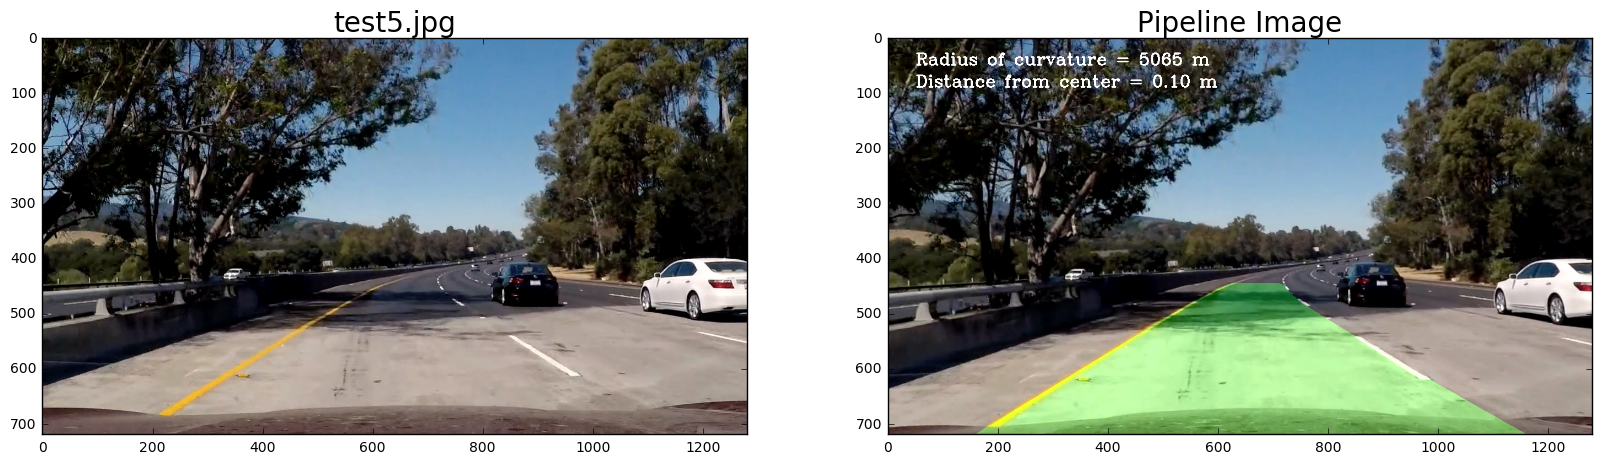

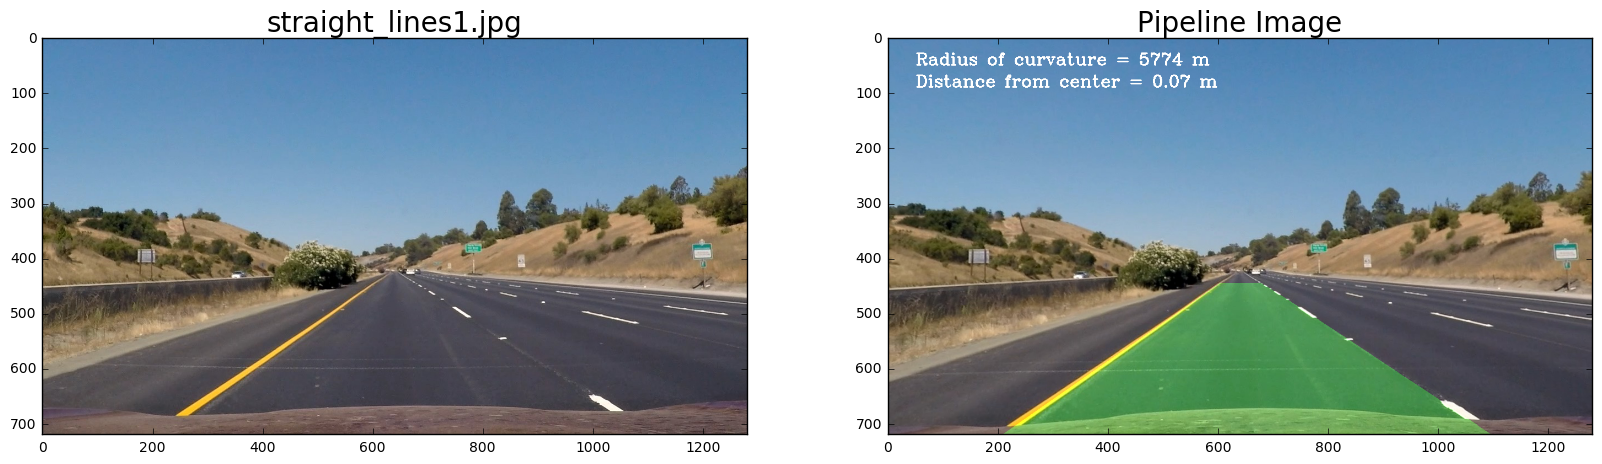

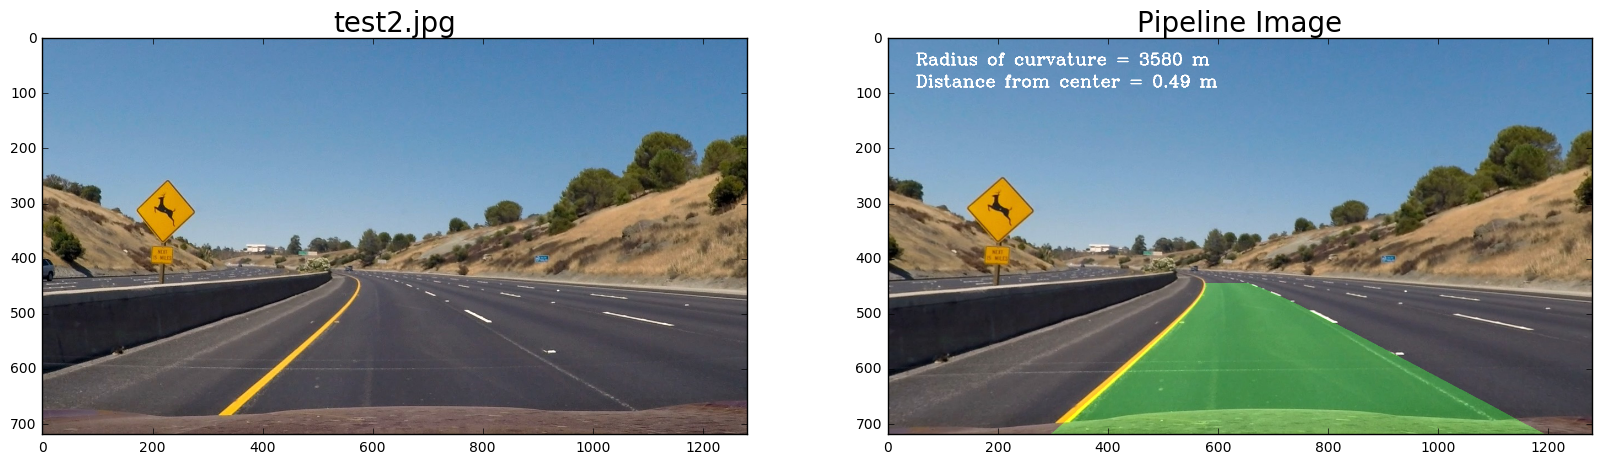

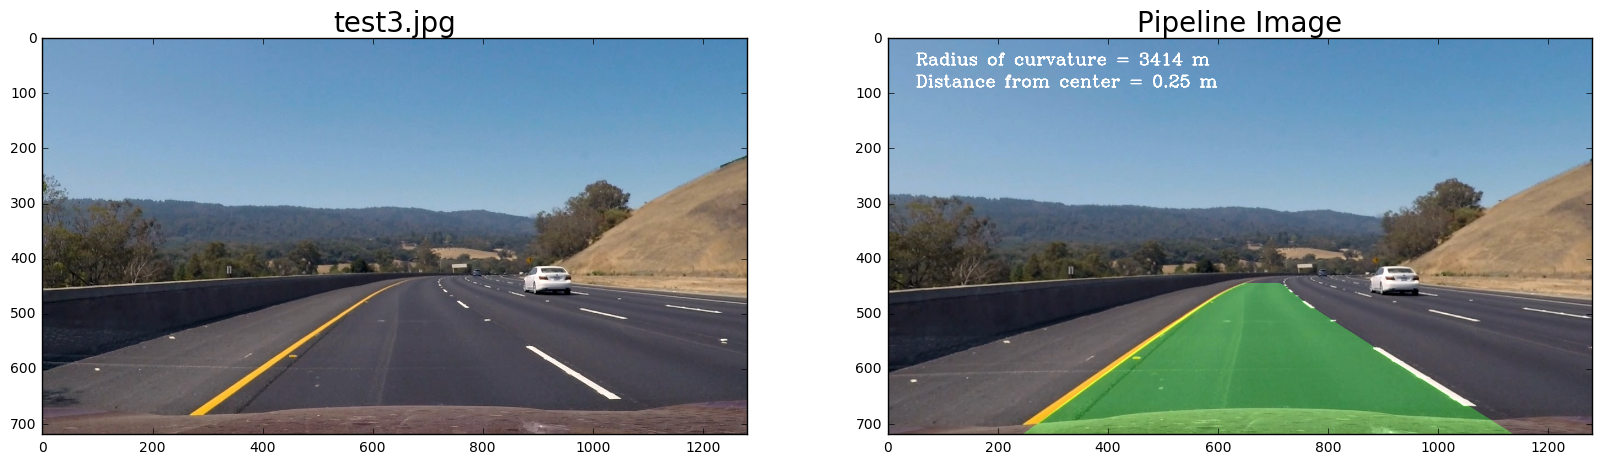

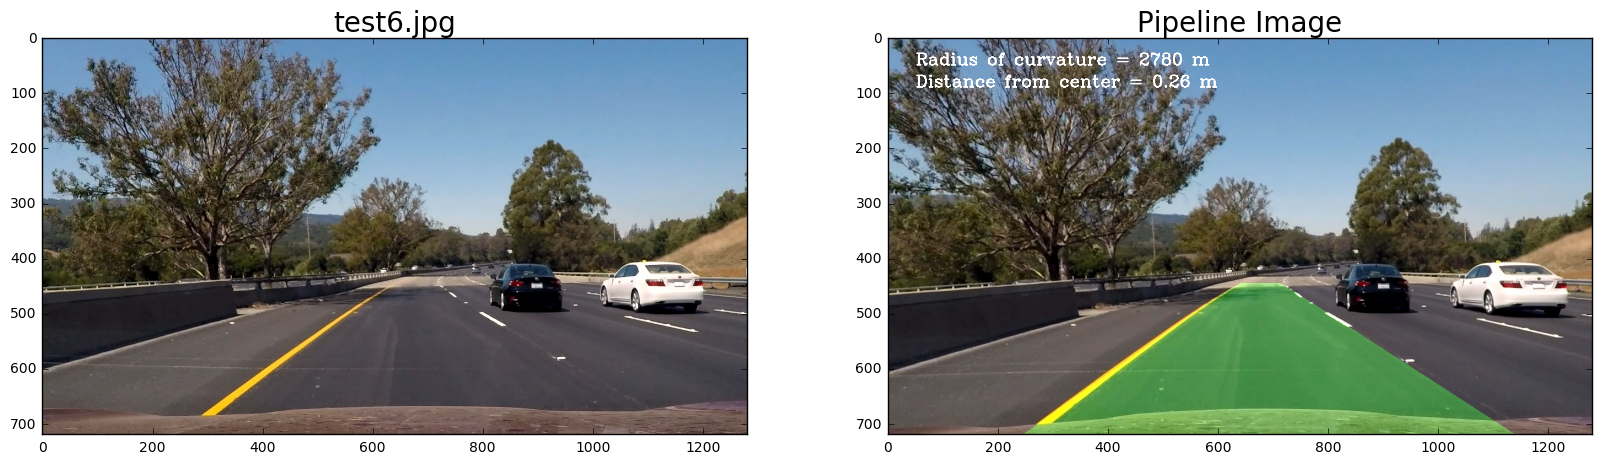

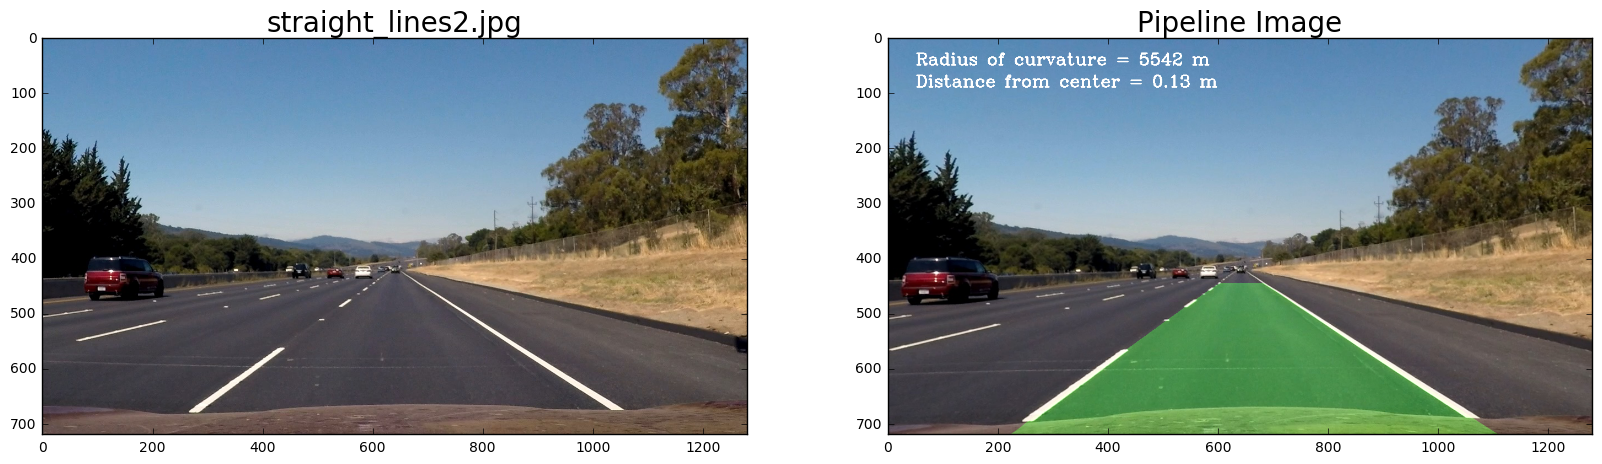

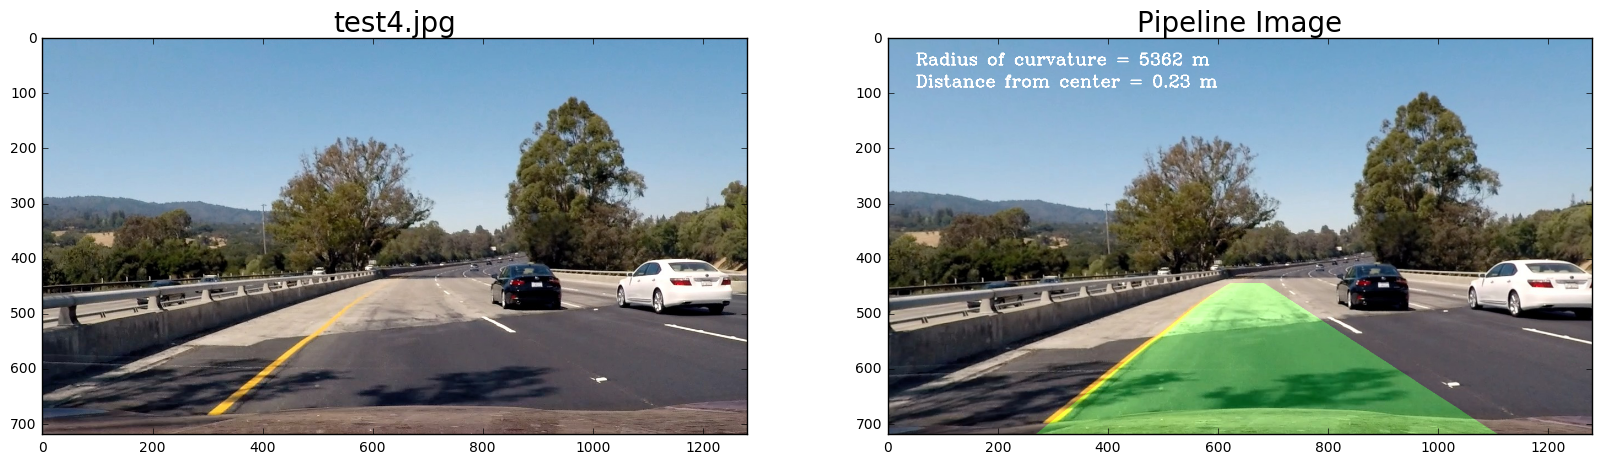

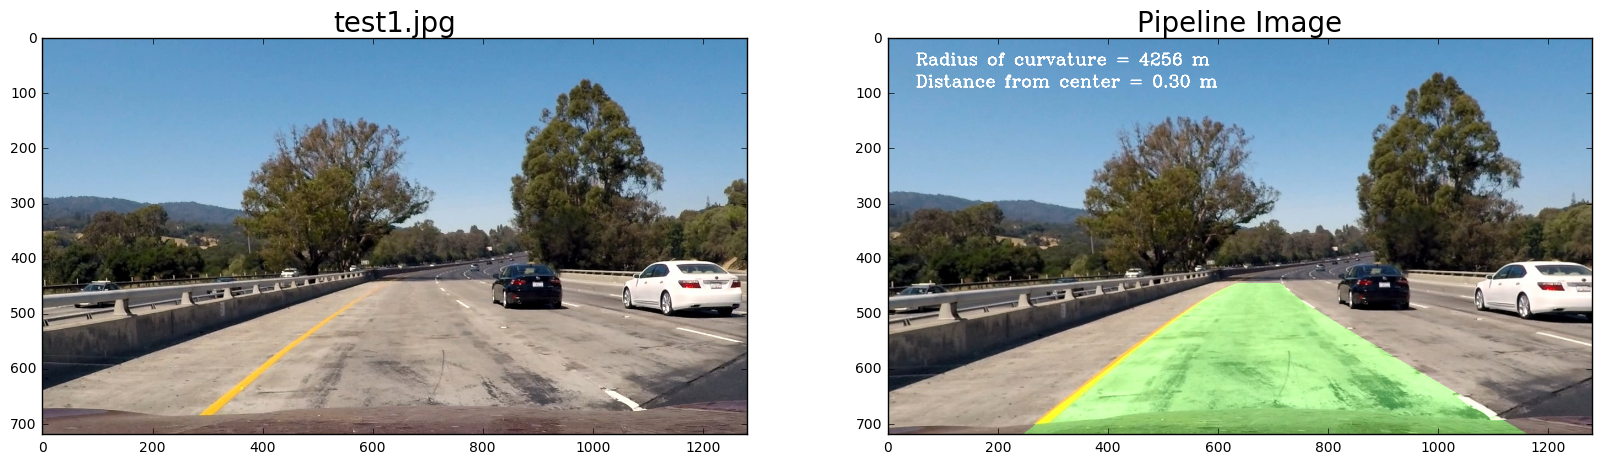

In [4]:
# Read the camera distortion pickle file and load mtx, dist
with open("camera_dist.p", mode='rb') as f:
    dist_pickle = pickle.load(f)
    
mtx, dist = dist_pickle["mtx"], dist_pickle["dist"]

# Read the perspective transform pickle file and load M, Minv
with open("M_and_Minv.p", mode='rb') as f:
    M_pickle = pickle.load(f)
    
M, Minv = M_pickle["M"], M_pickle["Minv"]

left_line = Line()
right_line = Line()

test_images = glob.glob('test_images/*.jpg')
for fname in test_images:
    image = mpimg.imread(fname)
    process_result = process_image(image)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(image)
    ax1.set_title(fname.replace('test_images/', ''), fontsize=20)
    ax2.imshow(process_result, cmap='gray')
    ax2.set_title('Pipeline Image', fontsize=20)